# Creación de un ejemplo adversarial

In [41]:

import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten ,Input
from keras.layers import Conv2D, MaxPooling2D, Reshape, Add
from keras.metrics import categorical_accuracy
from keras.regularizers import l1_l2, l2, l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from tensorflow.python.keras import backend as K
from keras.preprocessing.image import array_to_img,img_to_array

import matplotlib.pyplot as plt
import numpy as np

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

img_path = 'elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x_not_pre = x
x = preprocess_input(x)

##Funciones auxiliares
def plotImage( img, dims = False ):
    if not(dims):
        plt.imshow(img, vmin=0., vmax=1.)
    else: 
        plt.imshow(img.reshape(dims), vmin=0., vmax=1.)
    plt.show()
        



Eligamos una imagen para crear ejemplo adversarial

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


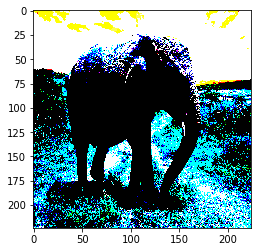

In [30]:
#select image to create an adversarial example from
img = x
plt.imshow(img.reshape((224,224,3)),vmin=0., vmax=1.)
plt.show()

Veamos qué clasificacion da el modelo

In [31]:
preds = model.predict(x)
print(preds.shape)
target = np.zeros((1,1000))
target[0,4] = 1
print('Predicted:', decode_predictions(target, top=3)[0])
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])
# Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]

(1, 1000)
Predicted: [('n01494475', 'hammerhead', 1.0), ('n15075141', 'toilet_tissue', 0.0), ('n02319095', 'sea_urchin', 0.0)]
Predicted: [('n02504458', 'African_elephant', 0.86625427), ('n02504013', 'Indian_elephant', 0.06860924), ('n01871265', 'tusker', 0.06478469)]


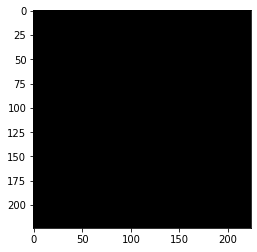

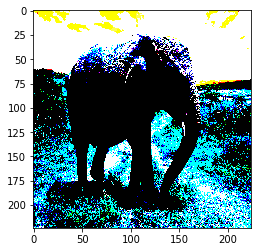

Predicted: [('n01930112', 'nematode', 0.07340607), ('n03729826', 'matchstick', 0.036409874), ('n03804744', 'nail', 0.030309401)]


In [40]:
#applying random noise does not fool the classifier
quantized_noise = np.round(np.random.normal(loc=0.0, scale=0.3, size=img.shape) * 255.) / 255.
noisy_img = np.clip(img + quantized_noise, 0., 1.)
#plt.imshow(quantized_noise[0],vmin=0., vmax=1.)
plotImage(quantized_noise[0])
#plt.show()
plotImage(noisy_img, (224,224,3))
preds = model.predict(noisy_img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
#### AQUI HAY ERROR
print('Predicted:', decode_predictions(preds, top=3)[0])

In [13]:

#custom activation function for keeping adversarial pixel values between 0.0 and 1.0
def clip(x):
    return K.clip(x, 0.0, 1.0)

#custom loss funciton for non-targeted misclassification
def negative_categorical_crossentropy(yTrue,yPred):
    return 0.0 - K.categorical_crossentropy(yTrue,yPred)

#add custom objects to dictionary
get_custom_objects().update({'clip': Activation(clip)})
get_custom_objects().update({'negative_categorical_crossentropy': negative_categorical_crossentropy})


#function for generating an adversarial example given a base image, adversarial class target, classifier, and regularization type
def generate_adversary(img,target,model,regularization,loss_function):
    
    #input for base image
    image = Input(shape=(224,224,3),name='image')
    #unit input for adversarial noise
    one = Input(shape=(1,),name='unity')
    
    #layer for learning adversarial noise to apply to image
    noise = Dense(224*224*3,activation = None,use_bias=False,kernel_initializer='random_normal',
                  kernel_regularizer=regularization, name='adversarial_noise')(one)
    
    #reshape noise in shape of image
    noise = Reshape((224,224,3),name='reshape')(noise)
    
    #add noise to image
    net = Add(name='add')([noise,image])
    #clip values to be within 0.0 and 1.0
    net = Activation('clip',name='clip_values')(net)
    
    #feed adversarial image to trained MNIST classifier
    outputs = model(net)

    adversarial_model = Model(inputs=[image,one], outputs=outputs)
    #freeze trained MNIST classifier layers
    adversarial_model.layers[-1].trainable = False
    
    adversarial_model.compile(optimizer='nadam', loss=loss_function, metrics=[categorical_accuracy])
        
    #target adversarial classification
    target_vector = np.zeros(10)
    target_vector[target] = 1.
    
    #callback for saving weights with smallest loss
    checkpoint = ModelCheckpoint('./adversarial_weights.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True,
                                 mode='auto', period=1)
    #train adversarial image
    adversarial_model.fit(x={'image':img,'unity':np.ones(shape=(1,1))},y=target_vector.reshape(1,-1),epochs=100,verbose=1,
                         callbacks=[checkpoint])
    #restore best weights
    adversarial_model.load_weights('./adversarial_weights.h5')
    
    #quantize adversarial noise
    quantized_weights = np.round(adversarial_model.get_weights()[0].reshape((224,224,3)) * 255.) / 255.
    
    #add trained weights to original image and clip values to produce adversarial image
    adversarial_img = np.clip(img.reshape((224,224,3)) + quantized_weights, 0., 1.)
    
    #display adversarial image
    plt.imshow(adversarial_img,vmin=0., vmax=1.)
    plt.show()
    #classify adversarial image
    #adversarial_prediction = mnist_model.predict(adversarial_img.reshape((1,28,28,1)))
    #print(adversarial_prediction)
    
    return adversarial_img

generate_adversary(img,5,model,l1(0.01),'negative_categorical_crossentropy')


Epoch 1/100


InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[1,1000] labels_size=[1,10]
	 [[node loss/resnet50_loss/negative_categorical_crossentropy/softmax_cross_entropy_with_logits (defined at /usr/local/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_keras_scratch_graph_40498]

Function call stack:
keras_scratch_graph
